In [1]:
import os
from os.path import splitext
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torchvision import transforms
from torchvision.models import DenseNet121_Weights

In [2]:
import os
import socket
import os
def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

os.environ["MASTER_PORT"] = str(find_free_port())
print(f"[INFO] Using MASTER_PORT={os.environ['MASTER_PORT']}")
from os.path import join, splitext
import json
from tqdm.notebook import tqdm
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from torchmetrics.classification import MultilabelAccuracy
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights, resnet152,ResNet152_Weights
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from utils import CheXpertGenDataset, CheXpertClsDataModule, CheXpertGenDataModule, CheXpertCNN, ensemble_pred

[INFO] Using MASTER_PORT=55297
[INFO] Using MASTER_PORT=51287


In [3]:
data_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus'

In [5]:
# set up a dataset
resnet152_data = CheXpertGenDataModule(data_dir=data_folder, transform=ResNet152_Weights.DEFAULT.transforms())
resnet152_data.setup('test')

  0%|          | 0/223462 [00:00<?, ?it/s]

In [6]:
len(resnet152_data.test_patient_id_set)

200

In [9]:
for batch in resnet152_data.test_dataloader():
    print(batch['images'].shape)
    # print(batch['findings'])
    # print(batch['impression'])

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 171, in collate
    {
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 172, in <dictcomp>
    key: collate(
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 3, 224, 224] at entry 0 and [2, 3, 224, 224] at entry 12


In [8]:
print(a['images'].shape)

NameError: name 'a' is not defined

In [5]:
batch['images'].shape

NameError: name 'batch' is not defined

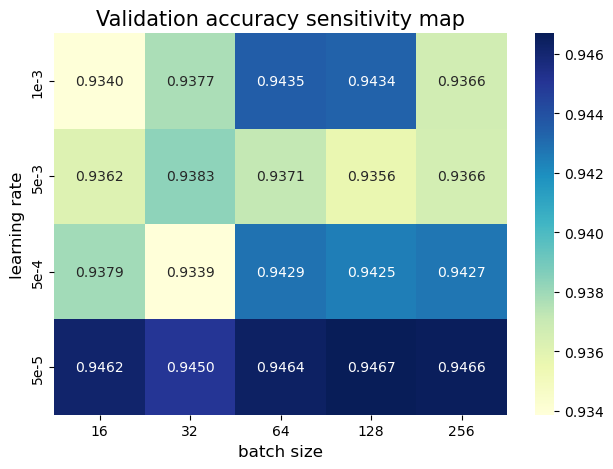

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

lr_list = ['1e-3', '5e-3', '5e-4', '5e-5']
batch_size_list = [16, 32, 64, 128, 256]
# Create a 2D matrix of values
data = np.array([
    [0.93397, 0.9377, 0.94352, 0.94336, 0.93664],
    [0.93617, 0.93833, 0.93713, 0.93558, 0.93661],
    [0.93789, 0.93387, 0.94286, 0.94246, 0.94273],
    [0.94617, 0.94499, 0.94636, 0.94669, 0.94657]
])

# Create the heatmap
sns.heatmap(data, annot=True, fmt=".4f", cmap="YlGnBu")

# Display the heatmap
plt.xticks(np.arange(len(batch_size_list))+0.5, batch_size_list)
plt.yticks(np.arange(len(lr_list))+0.5, lr_list)
plt.xlabel('batch size', fontsize=12)
plt.ylabel('learning rate', fontsize=12)
plt.title("Validation accuracy sensitivity map", fontsize=15)
plt.tight_layout()
plt.savefig('sensitivity_map.png', dpi=600)
plt.show()

### Not sure what this is

In [3]:
folder = 'mip_group_2/CheXpert Plus'

In [ ]:
df = pd.read_json(os.path.join(folder, "report_fixed.json"), lines=True)

In [ ]:
type_list = []
for path in df['path_to_image']:
    type_list.append(splitext(path)[0].split('/')[0])

In [ ]:
np.unique(type_list, return_counts=True)

(array(['train', 'valid'], dtype='<U5'), array([223228,    234]))

### Checkout what's inside data folder

In [11]:
data_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus'

In [12]:
os.listdir(data_folder)

['chexbert_labels.zip',
 'radgraph-XL-annotations',
 'PNG',
 'radgraph-XL-annotations.zip',
 'chexbert_labels',
 'df_chexpert_plus_240401.csv']

#### looks at how patients' images are split and stored in the folders

In [13]:
img_folder_path = os.path.join(data_folder, 'PNG')

In [14]:
img_folders = [folder for folder in os.listdir(img_folder_path) if splitext(folder)[1] == '']

In [15]:
img_folders

['png_chexpert_plus_chunk_0',
 'png_chexpert_plus_chunk_1',
 'png_chexpert_plus_chunk_3',
 'png_chexpert_plus_chunk_4',
 'png_chexpert_plus_chunk_2']

In [16]:
for folder in img_folders:
    img_subfolder = os.path.join(img_folder_path, folder)
    img_subfolder = os.path.join(img_subfolder, 'PNG')
    img_subfolder = os.path.join(img_subfolder, 'train')
    print(len(os.listdir(img_subfolder)))

5868
8171
18728
19722
12038


#### folder that has labels for data

In [17]:
os.listdir(os.path.join(data_folder, 'chexbert_labels'))

['report_fixed.json', 'findings_fixed.json', 'impression_fixed.json']

In [18]:
label_folder = os.path.join(data_folder, 'chexbert_labels')

#### paths of the input images and their labels

In [19]:
import json

file_path = os.path.join(label_folder, 'findings_fixed.json')

with open(file_path, 'r') as f:
    data = []
    for line in f:
        data.append(json.loads(line))  # Load each JSON object separately


for i in range(200, 205, 1):
    print(data[i])

{'path_to_image': 'train/patient16523/study1/view2_lateral.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 'Pneumothorax': None, 'Pleural Effusion': None, 'Pleural Other': None, 'Fracture': None, 'Support Devices': None, 'No Finding': 1.0}
{'path_to_image': 'train/patient16523/study11/view1_frontal.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 'Pneumothorax': None, 'Pleural Effusion': None, 'Pleural Other': None, 'Fracture': None, 'Support Devices': None, 'No Finding': 1.0}
{'path_to_image': 'train/patient16523/study16/view1_frontal.jpg', 'Enlarged Cardiomediastinum': None, 'Cardiomegaly': None, 'Lung Opacity': None, 'Lung Lesion': None, 'Edema': None, 'Consolidation': None, 'Pneumonia': None, 'Atelectasis': None, 

#### check up unique modes in data

In [20]:
mode_list = []
for label_dict in data:
    split_values_list = splitext(label_dict['path_to_image'])[0].split('/')
    mode = split_values_list[0] # train or test
    mode_list.append(mode)

In [21]:
np.unique(mode_list)

array(['train', 'valid'], dtype='<U5')

In [22]:
data[0]['path_to_image']

'train/patient42142/study5/view1_frontal.jpg'

In [23]:
len(data)

223462

In [24]:
data[0].items()

dict_items([('path_to_image', 'train/patient42142/study5/view1_frontal.jpg'), ('Enlarged Cardiomediastinum', None), ('Cardiomegaly', None), ('Lung Opacity', None), ('Lung Lesion', None), ('Edema', None), ('Consolidation', None), ('Pneumonia', None), ('Atelectasis', None), ('Pneumothorax', None), ('Pleural Effusion', None), ('Pleural Other', None), ('Fracture', None), ('Support Devices', None), ('No Finding', 1.0)])

#### see how many patients there are

In [25]:
int(splitext(data[0]['path_to_image'])[0].split('/')[1][7:])

42142

#### see how many images each patient has

[    1     2     3 ... 64738 64739 64740]


(array([40329., 14561.,  4724.,  2150.,  1082.,   593.,   431.,   242.,
          177.,    97.,    72.,    61.,    46.,    46.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36.,
        39., 42.]),
 <BarContainer object of 14 artists>)

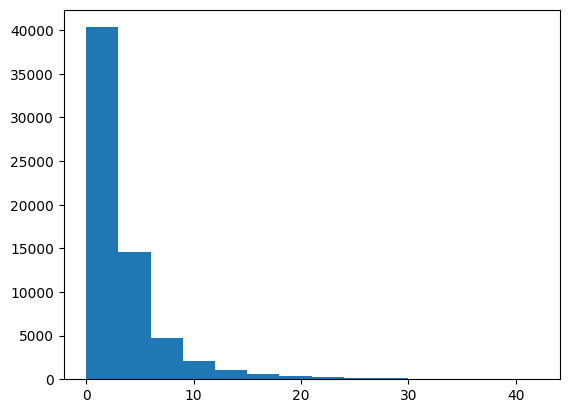

In [26]:
patient_list = []
for entry_dict in data:
    patient_list.append(int(splitext(entry_dict['path_to_image'])[0].split('/')[1][7:]))
uniq_patient_list, uniq_patient_cnt = np.unique(patient_list, return_counts=True)
print(uniq_patient_list)
plt.hist(uniq_patient_cnt, bins=np.arange(0, 45, 3))

#### open and transform the image files

In [27]:
transform = DenseNet121_Weights.DEFAULT.transforms()

In [28]:
for key, value in data[0].items():
    if key == 'path_to_image': # save image paths
        if splitext(value)[0].split('/')[0] == 'train':
            value = splitext(value)[0] + '.png'
            for folder in img_folders:
                img_subfolder_path = os.path.join(os.path.join(img_folder_path, folder), 'PNG')
                full_img_path = os.path.join(img_subfolder_path, value)
                if os.path.exists(full_img_path):
                    img = Image.open(full_img_path).convert("RGB") # convert to RGB
                    img = transform(img)

In [29]:
full_img_path = os.path.join(data_folder, 'PNG/png_chexpert_plus_chunk_1/PNG/train/patient32368/study1/view1_frontal.png')

In [31]:
img = Image.open(full_img_path).convert("RGB")

OSError: unrecognized data stream contents when reading image file

In [ ]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


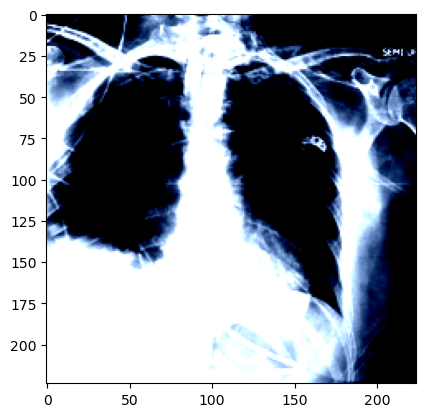

In [ ]:
plt.imshow(img.permute(1, 2, 0))

#### 14 disease types

In [32]:
disease_types = list(data[0].keys())[1:]

In [33]:
disease_types

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices',
 'No Finding']

In [35]:
img_type_list = []
disease_list = []
for disease_type in tqdm(disease_types):
    disease_type_list = []
    for label_dict in data:
        for key, value in label_dict.items():
            if key == 'path_to_image':
                img_type_list.append(splitext(value)[0].split('/')[0])
            elif key == disease_type:
                if value is None:
                    disease_type_list.append('None')
                else:
                    disease_type_list.append(value)
    disease_list.append(disease_type_list)

  0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
for i, disease_type in enumerate(disease_types):
    print(f'{disease_type}: {np.unique(disease_list[i], return_counts=True)}')

Enlarged Cardiomediastinum: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  6909,  12928,   4130, 199495]))
Cardiomegaly: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  1554,  11261,  10971, 199676]))
Lung Opacity: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   105,   1488,  32358, 189511]))
Lung Lesion: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   459,    329,   3490, 219184]))
Edema: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  2687,   4443,  12148, 204184]))
Consolidation: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  5938,   7083,   4159, 206282]))
Pneumonia: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  3702,    381,    915, 218464]))
Atelectasis: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([  8371,    167,   9136, 205788]))
Pneumothorax: (array(['-1.0', '0.0', '1.0', 'None'], dtype='<U32'), array([   702,  18577,   6391, 197792]))
Pleural Effusion

#### preset train/test split

In [37]:
np.unique(img_type_list, return_counts=True)

(array(['train', 'valid'], dtype='<U5'), array([3125192,    3276]))

#### patient ids

In [51]:
patient_id_list = [splitext(data[i]['path_to_image'])[0].split('/')[1][7:] for i in range(len(data))]

In [52]:
patient_id, patient_id_count = np.unique(patient_id_list, return_counts=True)

In [53]:
len(patient_id)

64725

In [42]:
patient_id

array(['00001', '00002', '00003', ..., '64738', '64739', '64740'],
      dtype='<U5')

Text(0, 0.5, 'x-ray counts')

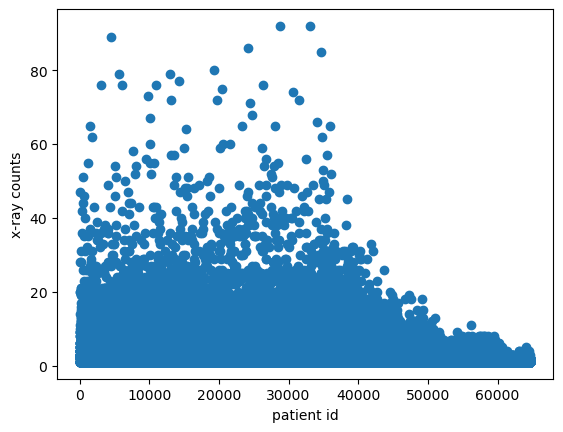

In [ ]:
plt.scatter(np.arange(len(patient_id)), patient_id_count)
plt.xlabel('patient id')
plt.ylabel('x-ray counts')

In [ ]:
np.argsort(patient_id_count)

array([   35,    39, 64705, ...,  4461, 33146, 28739], shape=(64725,))

In [ ]:
len(patient_id_count)

64725

In [ ]:
patient_id[28739]

np.str_('28746')

In [ ]:
patient_id_count[28739]

np.int64(92)

In [ ]:
type(patient_id_list[0])

str

In [ ]:
patient_28739_idx = np.where(np.array(patient_id_list)=='28746')[0]

In [ ]:
patient_28739_data = [data[i] for i in patient_28739_idx]

In [ ]:
angle_list = []
for patient_28739_d in patient_28739_data:
    angle_list.append(splitext(patient_28739_d['path_to_image'])[0].split('/')[-1][6:])

In [ ]:
np.unique(angle_list, return_counts=True)

(array(['frontal', 'lateral'], dtype='<U7'), array([89,  3]))

In [4]:
png_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG'

In [5]:
folders= os.listdir(png_folder)

In [6]:
# Filtering non-zip folders
non_zip_folders = [folder for folder in folders if not folder.endswith('.zip')]

# Iterating over the non-zip folders
for folder in non_zip_folders:
    print(f"Processing folder: {folder}")
    # Your processing code here

Processing folder: png_chexpert_plus_chunk_0
Processing folder: png_chexpert_plus_chunk_1
Processing folder: png_chexpert_plus_chunk_3
Processing folder: png_chexpert_plus_chunk_4
Processing folder: png_chexpert_plus_chunk_2


In [7]:
# Load the CSV file into a DataFrame
path = os.path.join(data_folder,'df_chexpert_plus_240401.csv')
df_all = pd.read_csv(path)

In [8]:
len(df_all)

223462

In [10]:
df_all

,path_to_image,path_to_dcm,frontal_lateral,ap_pa,deid_patient_id,patient_report_date_order,report,section_narrative,section_clinical_history,section_history,...,section_accession_number,age,sex,race,ethnicity,interpreter_needed,insurance_type,recent_bmi,deceased,split
0,train/patient42142/study5/view1_frontal.jpg,train/patient42142/study5/view1_frontal.dcm,Frontal,AP,patient42142,5,"NARRATIVE:\nChest 1 View, 8-8-2005\n \nHISTORY...","\nChest 1 View, 8-8-2005\n \n",NaN,"61 years Female, ICU patient\n \n",...,\n 9959089\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
1,train/patient42142/study8/view1_frontal.jpg,train/patient42142/study8/view1_frontal.dcm,Frontal,AP,patient42142,8,"NARRATIVE:\nChest 1 View, 7-11-2000\n \nHISTOR...","\nChest 1 View, 7-11-2000\n \n",NaN,"61 years Female, tracheostomy.\n \n",...,\n64048857\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
2,train/patient42142/study2/view1_frontal.jpg,train/patient42142/study2/view1_frontal.dcm,Frontal,AP,patient42142,2,"NARRATIVE:\nChest 1 View, 11-17-2018\n \nHISTO...","\nChest 1 View, 11-17-2018\n \n",NaN,"61 years Female, critical care follow-up\n \n",...,\n#2452\nThis report has been anonymized. All ...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
3,train/patient42142/study4/view1_frontal.jpg,train/patient42142/study4/view1_frontal.dcm,Frontal,AP,patient42142,4,NARRATIVE:\nAP PORTABLE UPRIGHT CHEST: May 01 ...,\nAP PORTABLE UPRIGHT CHEST: May 01 at 0518 ho...,ICU protocol. Follow up.\n \n,NaN,...,\n4164064\nThis report has been anonymized. Al...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
4,train/patient42142/study3/view1_frontal.jpg,train/patient42142/study3/view1_frontal.dcm,Frontal,AP,patient42142,3,"NARRATIVE:\nEXAM: Chest 1 View, 10/4/2\n \nCLI...","\nEXAM: Chest 1 View, 10/4/2\n \n",61 years Female UPRIGHT PLEASE. ICU PROTOCOL ...,NaN,...,\n49286401\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223457,train/patient59696/study1/view1_frontal.jpg,train/patient59696/study1/view1_frontal.dcm,Frontal,AP,patient59696,1,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 12/31...,"80 years of age, Female, Pulmonary edema.\n \n",NaN,...,\n#7n4778536837\nThis report has been anonymiz...,81.0,Female,White,Non-Hispanic/Non-Latino,No,Medicare,24.0,No,train
223458,train/patient24732/study1/view1_frontal.jpg,train/patient24732/study1/view1_frontal.dcm,Frontal,PA,patient24732,1,"NARRATIVE:\nEXAM: Chest 1 View, 6/8/04.\n \nHI...","\nEXAM: Chest 1 View, 6/8/04.\n \n",NaN,"26 years Male, DXCH1; + QUANT, R/O PULMONARY ...",...,\n83-69-35-98\nThis report has been anonymized...,27.0,Male,Asian,Non-Hispanic/Non-Latino,No,Unknown,NaN,No,train
223459,train/patient12591/study1/view1_frontal.jpg,train/patient12591/study1/view1_frontal.dcm,Frontal,AP,patient12591,1,NARRATIVE:\nCHEST AP PORTABLE: 8-21-2000\nCLIN...,\nCHEST AP PORTABLE: 8-21-2000\n,"65-year-old male with brain mass, status post...",NaN,...,\n5315047989368\nThis report has been anonymiz...,66.0,Male,Unknown,Unknown,No,Medicare,NaN,Yes,train
223460,train/patient37553/study1/view1_frontal.jpg,train/patient37553/study1/view1_frontal.dcm,Frontal,AP,patient37553,1,NARRATIVE:\nCHEST: 2/27/2005\nCOMPARISON: 2/27...,\nCHEST: 2/27/2005\n,A 77-year-old male with parotid cancer.\n,NaN,...,\n#623485267\nThis report has been anonymized....,77.0,Male,Unknown,Unknown,Unknown,Medicare,NaN,No,train


In [20]:
df.columns

Index(['path_to_image', 'path_to_dcm', 'frontal_lateral', 'ap_pa',
       'deid_patient_id', 'patient_report_date_order', 'report',
       'section_narrative', 'section_clinical_history', 'section_history',
       'section_comparison', 'section_technique', 'section_procedure_comments',
       'section_findings', 'section_impression', 'section_end_of_impression',
       'section_summary', 'section_accession_number', 'age', 'sex', 'race',
       'ethnicity', 'interpreter_needed', 'insurance_type', 'recent_bmi',
       'deceased', 'split'],
      dtype='object')

In [17]:
df['section_impression']

0           \n \n1.TRACHEOSTOMY TUBE REMAINS IN PLACE.  ...
1           \n \n1.TRACHEOSTOMY AND SUBDIAPHRAGMATIC ENT...
2           \n \n1.SINGLE PORTABLE SEMIUPRIGHT AP VIEW O...
3         \n \n 1.  PATCHY SUBSEGMENTAL BIBASILAR (LEFT ...
4         \n \n1.UPRIGHT FRONTAL VIEW OF THE CHEST DEMON...
                                ...                        
223457    \n \n1.  Decreased pulmonary edema. Otherwise,...
223458    \n \nLUNGS GROSSLY CLEAR. NO EVIDENCE OF AIR S...
223459    \n1. AP UPRIGHT VIEW OF THE CHEST DEMONSTRATES...
223460    \nAP UPRIGHT VIEW OF THE CHEST DEMONSTRATES IN...
223461    \n \nCARDIAC SILHOUETTE REMAINS ENLARGED.  AOR...
Name: section_impression, Length: 223462, dtype: object

In [3]:
patient_id_set = {'04528', '11162', '32368'}

In [46]:
df_all.head(10)

,path_to_image,path_to_dcm,frontal_lateral,ap_pa,deid_patient_id,patient_report_date_order,report,section_narrative,section_clinical_history,section_history,...,section_accession_number,age,sex,race,ethnicity,interpreter_needed,insurance_type,recent_bmi,deceased,split
0,train/patient42142/study5/view1_frontal.jpg,train/patient42142/study5/view1_frontal.dcm,Frontal,AP,patient42142,5,"NARRATIVE:\nChest 1 View, 8-8-2005\n \nHISTORY...","\nChest 1 View, 8-8-2005\n \n",NaN,"61 years Female, ICU patient\n \n",...,\n 9959089\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
1,train/patient42142/study8/view1_frontal.jpg,train/patient42142/study8/view1_frontal.dcm,Frontal,AP,patient42142,8,"NARRATIVE:\nChest 1 View, 7-11-2000\n \nHISTOR...","\nChest 1 View, 7-11-2000\n \n",NaN,"61 years Female, tracheostomy.\n \n",...,\n64048857\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
2,train/patient42142/study2/view1_frontal.jpg,train/patient42142/study2/view1_frontal.dcm,Frontal,AP,patient42142,2,"NARRATIVE:\nChest 1 View, 11-17-2018\n \nHISTO...","\nChest 1 View, 11-17-2018\n \n",NaN,"61 years Female, critical care follow-up\n \n",...,\n#2452\nThis report has been anonymized. All ...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
3,train/patient42142/study4/view1_frontal.jpg,train/patient42142/study4/view1_frontal.dcm,Frontal,AP,patient42142,4,NARRATIVE:\nAP PORTABLE UPRIGHT CHEST: May 01 ...,\nAP PORTABLE UPRIGHT CHEST: May 01 at 0518 ho...,ICU protocol. Follow up.\n \n,NaN,...,\n4164064\nThis report has been anonymized. Al...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
4,train/patient42142/study3/view1_frontal.jpg,train/patient42142/study3/view1_frontal.dcm,Frontal,AP,patient42142,3,"NARRATIVE:\nEXAM: Chest 1 View, 10/4/2\n \nCLI...","\nEXAM: Chest 1 View, 10/4/2\n \n",61 years Female UPRIGHT PLEASE. ICU PROTOCOL ...,NaN,...,\n49286401\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
5,train/patient42142/study7/view1_frontal.jpg,train/patient42142/study7/view1_frontal.dcm,Frontal,AP,patient42142,7,"NARRATIVE:\nChest 1 View, 1-29-2017\n \nHISTOR...","\nChest 1 View, 1-29-2017\n \n",NaN,"61 years Female, shortness of breath\n \n",...,\n04240392\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
6,train/patient42142/study1/view1_frontal.jpg,train/patient42142/study1/view1_frontal.dcm,Frontal,AP,patient42142,1,"NARRATIVE:\nChest 1 View, 2004/20\n \nHISTORY:...","\nChest 1 View, 2004/20\n \n",NaN,"61 years Female, Line placement\n \n",...,\nljnagnwl\nThis report has been anonymized. A...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
7,train/patient42142/study6/view1_frontal.jpg,train/patient42142/study6/view1_frontal.dcm,Frontal,AP,patient42142,6,"NARRATIVE:\nChest 1 View, 1/16/2016\n \nHISTOR...","\nChest 1 View, 1/16/2016\n \n",NaN,"61 years Female, ICU patient\n \n",...,\n36157\nThis report has been anonymized. All ...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,22.2,No,train
8,train/patient04528/study1/view2_lateral.jpg,train/patient04528/study1/view2_lateral.dcm,Lateral,NaN,patient04528,1,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 6/3/1...,"61 years of age, Female, R o infiltarate..AML...",NaN,...,\nRUFLZXH\nThis report has been anonymized. Al...,62.0,Female,White,Non-Hispanic/Non-Latino,No,Private Insurance,24.9,Yes,train
9,train/patient04528/study1/view1_frontal.jpg,train/patient04528/study1/view1_frontal.dcm,Frontal,PA,patient04528,2,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...,\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28...,"61 years of age, Female, R o infiltarate..AML...",NaN,...,\n716611072\nThis report has

In [46]:
img_dict = {}
text_dict = {}

In [47]:
patient_id_set = set()
for idx in tqdm(range(len(df_all))):
    img_path = df_all.iloc[idx]['path_to_image']
    img_path_list = splitext(img_path)[0].split('/')
    patient_id = img_path_list[1][7:]
    patient_id_set.add(patient_id)
    study_num = img_path_list[2]
    if patient_id in patient_id_set:
        patient_id_study_num = f'patient{patient_id}/{study_num}'
        if patient_id_study_num not in img_dict:
            # add list of images to the same study of a patient
            img_paths_list = ['/'.join(img_path_list) + '.png']
            img_dict[patient_id_study_num] = img_paths_list

            # add findings and impression texts to a list
            section_reports_list = []
            section_findings = df_all.iloc[idx]['section_findings']
            if isinstance(section_findings, str) and len(section_findings.split()) >= 2:
                section_findings = section_findings.strip().replace('\n', '').replace('..', '.') # strips mostly '/n'
                section_findings = '. '.join([s.strip().capitalize() for s in section_findings.split('.')]).strip() # lower caps
                section_reports_list.append(section_findings)
            else:
                section_reports_list.append('[NF]')
            section_impression = df_all.iloc[idx]['section_impression']
            if isinstance(section_impression, str) and len(section_impression.split()) >= 2:
                section_impression = section_impression.strip().replace('\n', '').replace('..', '.') # strips mostly '/n'
                section_impression = '. '.join([s.strip().capitalize() for s in section_impression.split('.')]).strip() # lower caps
                section_reports_list.append(section_impression)
            else:
                section_reports_list.append('[NI]')
            text_dict[patient_id_study_num] = section_reports_list
        else:
            img_dict[patient_id_study_num].append('/'.join(img_path_list) + '.png')

  0%|          | 0/223462 [00:00<?, ?it/s]

In [48]:
len(patient_id_set)

64725

In [49]:
patient_id_set

{'54862',
 '23473',
 '47557',
 '29366',
 '29751',
 '59466',
 '48141',
 '20697',
 '02564',
 '03435',
 '33906',
 '28686',
 '53612',
 '37138',
 '34489',
 '12969',
 '07999',
 '11989',
 '18624',
 '43941',
 '21475',
 '57130',
 '40857',
 '36300',
 '04373',
 '52661',
 '18692',
 '28896',
 '32059',
 '30561',
 '07534',
 '22108',
 '49700',
 '54494',
 '12573',
 '49039',
 '25166',
 '12825',
 '50072',
 '53996',
 '52559',
 '60888',
 '46649',
 '50320',
 '01451',
 '17538',
 '51173',
 '26495',
 '53816',
 '58420',
 '16730',
 '50962',
 '10718',
 '23615',
 '31089',
 '50289',
 '55765',
 '50284',
 '63751',
 '00746',
 '54550',
 '55620',
 '62529',
 '24472',
 '51957',
 '08352',
 '40276',
 '51966',
 '22178',
 '25817',
 '16310',
 '12019',
 '32399',
 '56426',
 '25857',
 '56151',
 '49629',
 '43040',
 '62266',
 '59204',
 '13565',
 '48942',
 '45351',
 '22235',
 '48674',
 '02932',
 '56249',
 '36952',
 '32168',
 '58425',
 '64739',
 '08245',
 '00756',
 '19244',
 '12330',
 '54565',
 '11485',
 '48052',
 '59126',
 '62730',


In [56]:
patient_id

array(['00001', '00002', '00003', ..., '64738', '64739', '64740'],
      dtype='<U5')

In [57]:
patient_id_set - set(patient_id)

set()

In [34]:
img_dict

{'patient04528/study1': ['train/patient04528/study1/view2_lateral.png',
  'train/patient04528/study1/view1_frontal.png'],
 'patient11162/study3': ['train/patient11162/study3/view1_frontal.png'],
 'patient11162/study5': ['train/patient11162/study5/view1_frontal.png',
  'train/patient11162/study5/view2_lateral.png'],
 'patient11162/study1': ['train/patient11162/study1/view1_frontal.png'],
 'patient11162/study4': ['train/patient11162/study4/view2_lateral.png',
  'train/patient11162/study4/view1_frontal.png'],
 'patient11162/study6': ['train/patient11162/study6/view1_frontal.png',
  'train/patient11162/study6/view2_lateral.png'],
 'patient11162/study2': ['train/patient11162/study2/view1_frontal.png']}

In [35]:
text_dict

{'patient04528/study1': ['Unchanged position of the left upper extremity picc line. Again seen are surgical clips projecting over the right hemithorax. The cardiomediastinal silhouette is stable in appearance. Increased stranding opacities are noted in the left retrocardiac region. Subtle stranding opacities in the right upper lung zone are unchanged. There are no pleural or significant bony abnormalities. Absence of the right breast shadow compatible with prior mastectomy.',
  '1. Interval development of a band of increased linear stranding opacities in the left retrocardiac region. Although this may represent subsegmental atelectasis, an early or developing consolidation could have similar appearance. Recommend clinical correlation.'],
 'patient11162/study3': ['There is redemonstration of right internal jugular central venousline, right internal jugular sheath, two mediastinal drains,sternotomy wires, and mediastinal surgical clips. Lung volumeshave increased compared with the prior 

In [24]:
text_dict['patient11162/study4'][1]

'STABLE POSTOPERATIVE APPEARANCE OF THE MEDIASTINUM. BILATERAL TINYPLEURAL EFFUSIONS OR PLEURAL THICKENING PERSIST. NO PULMONARYEDEMA. THE LUNGS ARE CLEAR.'

In [27]:
text_dict['patient11162/study4'][1].split('.')

['STABLE POSTOPERATIVE APPEARANCE OF THE MEDIASTINUM',
 ' BILATERAL TINYPLEURAL EFFUSIONS OR PLEURAL THICKENING PERSIST',
 ' NO PULMONARYEDEMA',
 ' THE LUNGS ARE CLEAR',
 '']

In [31]:
'. '.join([s.strip().capitalize() for s in text_dict['patient11162/study4'][1].split('.')]).strip()

'Stable postoperative appearance of the mediastinum. Bilateral tinypleural effusions or pleural thickening persist. No pulmonaryedema. The lungs are clear.'

In [79]:
df.iloc[0]['path_to_image']

'train/patient04528/study1/view2_lateral.jpg'

In [68]:
print(df.iloc[2]['section_impression'])


IMPROVED LUNG VOLUMES WITH DECREASED BIBASILAR ATELECTASIS, AS WELL
AS DECREASED PULMONARY EDEMA.



In [69]:
print(df.iloc[3]['section_impression'])


SLIGHT INTERVAL INCREASE IN LEFT PLEURAL EFFUSION. OTHERWISE, NO
SIGNIFICANT INTERVAL CHANGE.



In [70]:
print(df.iloc[4]['section_impression'])


SLIGHT INTERVAL INCREASE IN LEFT PLEURAL EFFUSION. OTHERWISE, NO
SIGNIFICANT INTERVAL CHANGE.



In [91]:
class CheXpertGenDataset(Dataset):
    def __init__(self, root_dir, patient_id_set, transform):
        """
        Args:
            root_dir (str): Path to the parent directory containing subdirectories (e.g., 'label_folder').
            transform (callable, optional): Optional transform to be applied on an image.
            mode (str): Either "train" or "valid" to select the correct folder.
        """
        self.root = root_dir
        self.imgs_path = os.path.join(self.root, 'PNG')
        self.img_folders = [folder for folder in os.listdir(self.imgs_path) if splitext(folder)[1] == '']

        self.label_path = os.path.join(self.root, 'df_chexpert_plus_240401.csv')
        # load a dataframe of image paths and radiologist report texts
        self.chexpert_df = pd.read_csv(self.label_path)

        self.patient_id_study_num_set = set()
        self.patient_id_study_num_list = []
        self.img_dict = {}
        self.text_dict = {}
        self.img_value_exception = 'train/patient32368/study1/view1_frontal.jpg'
        self.transform = transform

        for idx in tqdm(range(len(self.chexpert_df))):
            img_value = self.chexpert_df.iloc[idx]['path_to_image']
            if img_value != self.img_value_exception:
                img_value_list = splitext(img_value)[0].split('/')
                for folder in self.img_folders:
                    img_subfolder_path = os.path.join(os.path.join(self.imgs_path, folder), 'PNG')
                    img_path_temp = os.path.join(img_subfolder_path, '/'.join(img_value_list) + '.png')
                    if os.path.exists(img_path_temp):
                        img_path = img_path_temp

                patient_id = img_value_list[1][7:]
                study_num = img_value_list[2]
                if patient_id in patient_id_set:
                    patient_id_study_num = f'patient{patient_id}/{study_num}'
                    self.patient_id_study_num_set.add(patient_id_study_num)

                    if patient_id_study_num not in self.img_dict:
                        # add list of images to the same study of a patient
                        img_paths_list = [img_path]
                        self.img_dict[patient_id_study_num] = img_paths_list

                        # add findings and impression texts to a list
                        section_reports_dict = {}
                        section_findings = self.chexpert_df.iloc[idx]['section_findings']
                        if isinstance(section_findings, str) and len(section_findings.split()) >= 2:
                            section_findings = section_findings.strip().replace('\n', '').replace('..', '.') # strips mostly '\n'
                            section_findings = '. '.join([s.strip().capitalize() for s in section_findings.split('.')]).strip() # lower caps
                            section_reports_dict['findings'] = section_findings
                        else:
                            section_reports_dict['findings'] = '[NF]'
                        section_impression = self.chexpert_df.iloc[idx]['section_impression']
                        if isinstance(section_impression, str) and len(section_impression.split()) >= 2:
                            section_impression = section_impression.strip().replace('\n', '').replace('..', '.') # strips mostly '\n'
                            section_impression = '. '.join([s.strip().capitalize() for s in section_impression.split('.')]).strip() # lower caps
                            section_reports_dict['impression'] = section_impression
                        else:
                            section_reports_dict['impression'] = '[NI]'
                        self.text_dict[patient_id_study_num] = section_reports_dict
                    else:
                        self.img_dict[patient_id_study_num].append(img_path)
        self.patient_id_study_num_list = list(self.patient_id_study_num_set)

    def __len__(self):
        assert len(self.img_dict) == len(self.text_dict)
        assert len(self.patient_id_study_num_list) == len(self.img_dict)
        return len(self.img_dict)

    def __getitem__(self, idx):
        item = {}
        # open images and transform to tensor
        patient_id_study_num = self.patient_id_study_num_list[idx]
        img_paths = self.img_dict[patient_id_study_num]
        img_list = []
        for img_path in img_paths:
            img = Image.open(img_path).convert("RGB")  # convert to RGB
            img = self.transform(img)
            img = img.to(torch.float32)
            img_list.append(img)
        img = torch.stack(img_list, dim=0)
        item['images'] = img
        item['findings'] = self.text_dict[patient_id_study_num]['findings']
        item['impression'] = self.text_dict[patient_id_study_num]['impression']
        return item

In [4]:
chexpert_dataset = CheXpertGenDataset(root_dir=data_folder, patient_id_set=patient_id_set, transform=ResNet152_Weights.DEFAULT.transforms())

  0%|          | 0/223462 [00:00<?, ?it/s]

In [5]:
len(chexpert_dataset)

7

In [6]:
chexpert_dataset.patient_id_study_num_list

['patient11162/study1',
 'patient11162/study6',
 'patient11162/study2',
 'patient11162/study4',
 'patient11162/study3',
 'patient11162/study5',
 'patient04528/study1']

In [94]:
chexpert_dataset[0]['images'].shape

torch.Size([2, 3, 224, 224])

In [95]:
chexpert_dataset[0]['findings']

'Unchanged position of the left upper extremity picc line. Again seen are surgical clips projecting over the right hemithorax. The cardiomediastinal silhouette is stable in appearance. Increased stranding opacities are noted in the left retrocardiac region. Subtle stranding opacities in the right upper lung zone are unchanged. There are no pleural or significant bony abnormalities. Absence of the right breast shadow compatible with prior mastectomy.'

In [96]:
chexpert_dataset[0]['impression']

'1. Interval development of a band of increased linear stranding opacities in the left retrocardiac region. Although this may represent subsegmental atelectasis, an early or developing consolidation could have similar appearance. Recommend clinical correlation.'

In [86]:
chexpert_dataset.patient_id_study_num_list[3]

'patient11162/study1'

In [87]:
img, text = chexpert_dataset[3]

In [88]:
type(img)

torch.Tensor

In [89]:
img.shape

torch.Size([1, 3, 224, 224])

In [90]:
text

['[NF]',
 '1. There is a right pleural effusion. There is a left anteriorchest wall aicd. There is no pneumothorax.']

In [77]:
len(chexpert_dataset)

7

In [56]:
chexpert_dataset.img_dict

{'patient04528/study1': ['../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/PNG/train/patient04528/study1/view2_lateral.png',
  '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/PNG/train/patient04528/study1/view1_frontal.png'],
 'patient11162/study3': ['../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/PNG/train/patient11162/study3/view1_frontal.png'],
 'patient11162/study5': ['../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/PNG/train/patient11162/study5/view1_frontal.png',
  '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/PNG/train/patient11162/study5/view2_lateral.png'],
 'patient11162/study1': ['../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus/PNG/png_chexpert_plus_chunk_0/P

In [50]:
chexpert_dataset.text_dict

{'patient04528/study1': ['Unchanged position of the left upper extremity picc line. Again seen are surgical clips projecting over the right hemithorax. The cardiomediastinal silhouette is stable in appearance. Increased stranding opacities are noted in the left retrocardiac region. Subtle stranding opacities in the right upper lung zone are unchanged. There are no pleural or significant bony abnormalities. Absence of the right breast shadow compatible with prior mastectomy.',
  '1. Interval development of a band of increased linear stranding opacities in the left retrocardiac region. Although this may represent subsegmental atelectasis, an early or developing consolidation could have similar appearance. Recommend clinical correlation.'],
 'patient11162/study3': ['There is redemonstration of right internal jugular central venousline, right internal jugular sheath, two mediastinal drains,sternotomy wires, and mediastinal surgical clips. Lung volumeshave increased compared with the prior 

In [45]:
df = df_all[df_all['section_impression'].apply(lambda x: isinstance(x, str) and len(x.split()) < 2)]

In [46]:
df['section_impression']

4152                        \n
4164                        \n
16055     \n \n1.     \n \n \n
16059     \n \n1.     \n \n \n
19185                       \n
27279                       \n
33708                       \n
44285                       \n
44291                       \n
66881                       \n
66907                       \n
114158     \n \n1.CHF.\n \n \n
120915                   \n \n
135342                      \n
135345                      \n
139264                      \n
148627              \n \nTHE\n
156421                      \n
156428                      \n
164813                      \n
172459                   \n \n
198841                      \n
202708                      \n
209671                      \n
223099                      \n
Name: section_impression, dtype: object

In [36]:
len(df)

25

In [ ]:
df = df[df['section_impression'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 2)]

In [27]:
df = df[df['section_impression'].apply(lambda x: isinstance(x, str))]

In [28]:
len(df)

223317

In [8]:
df['section_findings']

0                                                       NaN
1                                                       NaN
2                                                       NaN
3                                                       NaN
4                                                       NaN
                                ...                        
223457    \n \nUnchanged right internal jugular venous c...
223458                                                  NaN
223459                                                  NaN
223460                                                  NaN
223461                                                  NaN
Name: section_findings, Length: 223462, dtype: object

In [56]:
df = df_all[df_all['section_findings'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 2)]

In [57]:
df['section_findings']

8         \n \nUnchanged position of the left upper extr...
9         \n \nUnchanged position of the left upper extr...
15        \nThere is redemonstration of right internal j...
16         Persistent small bilateral pleural effusions....
20         Persistent small bilateral pleural effusions....
                                ...                        
223444    \n \nThere is complete consolidation of the ri...
223449    \nLow lung volumes. Probable small left pleura...
223454       The initial examination 6/29/2009 at 1747 d...
223456     Portable upright frontal chest radiograph dem...
223457    \n \nUnchanged right internal jugular venous c...
Name: section_findings, Length: 57805, dtype: object

In [58]:
len(df)

57805

In [82]:
df = df_all[df_all['section_findings'].apply(lambda x: isinstance(x, str))]

# path2 = os.path.join(data_folder,'radgraph-XL-annotations')

In [83]:
len(df)

59469

In [84]:
df = df[df['section_findings'].apply(lambda x: isinstance(x, str))]

In [85]:
len(df)

59469

In [86]:
df['section_findings'].iloc[0]

'\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable in appearance. Increased \nstranding opacities are noted in the left retrocardiac region. Subtle \nstranding opacities in the right upper lung zone are unchanged.. \nThere are no pleural or significant bony abnormalities. Absence of \nthe right breast shadow compatible with prior mastectomy.\n \n'

In [35]:
df['section_findings'].iloc[0].strip().replace('\n', '').replace('..', '.')

'Unchanged position of the left upper extremity PICC line. Again seen are surgical clips projecting over the right hemithorax. The cardiomediastinal silhouette is stable in appearance. Increased stranding opacities are noted in the left retrocardiac region. Subtle stranding opacities in the right upper lung zone are unchanged. There are no pleural or significant bony abnormalities. Absence of the right breast shadow compatible with prior mastectomy.'

In [22]:
print(df['section_findings'].iloc[0])


 
Unchanged position of the left upper extremity PICC line. Again seen 
are surgical clips projecting over the right hemithorax. The 
cardiomediastinal silhouette is stable in appearance. Increased 
stranding opacities are noted in the left retrocardiac region. Subtle 
stranding opacities in the right upper lung zone are unchanged.. 
There are no pleural or significant bony abnormalities. Absence of 
the right breast shadow compatible with prior mastectomy.
 



In [ ]:
df.iloc[0]

path_to_image                       train/patient04528/study1/view2_lateral.jpg
path_to_dcm                         train/patient04528/study1/view2_lateral.dcm
frontal_lateral                                                         Lateral
ap_pa                                                                       NaN
deid_patient_id                                                    patient04528
patient_report_date_order                                                     1
report                        NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...
section_narrative             \nRADIOGRAPHIC EXAMINATION OF THE CHEST: 6/3/1...
section_clinical_history       61 years of age, Female, R o infiltarate..AML...
section_history                                                             NaN
section_comparison                                                 06/2017\n \n
section_technique                                                           NaN
section_procedure_comments              

In [ ]:
df.iloc[0]['report']

'NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 6/3/17\n \nCLINICAL HISTORY: 61 years of age, Female, R o infiltarate..AML \n(acute myeloblastic leukemia)\n \nCOMPARISON: 06/2017\n \nPROCEDURE COMMENTS: Two views of the chest. \n \nFINDINGS:\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable in appearance. Increased \nstranding opacities are noted in the left retrocardiac region. Subtle \nstranding opacities in the right upper lung zone are unchanged.. \nThere are no pleural or significant bony abnormalities. Absence of \nthe right breast shadow compatible with prior mastectomy.\n \nIMPRESSION:\n \n1.  Interval development of a band of increased linear stranding \nopacities in the left retrocardiac region. Although this may \nrepresent subsegmental atelectasis, an early or developing \nconsolidation could have similar appearance. Recommend clinical \ncorrela